In [1]:
import casatools
import numpy as np 
import matplotlib.pyplot as plt 
%config InlineBackend.figure_format = 'retina'
from scipy.interpolate import interp1d

# initialize the relevant CASA tools
tb = casatools.table()
ms = casatools.ms()

filename = "calibrator_data_spw25_FDM.ms"

Our goal here is try to understand the spectral correlations of the noise. We're using observations of a bandpass calibrator assumed to be spectrally flat (after calibration).

In [2]:
tb.open(filename)
colnames = tb.colnames()
spw_id = tb.getcol("DATA_DESC_ID")  # array of int with shape [npol, nchan, nvis]
field_id = tb.getcol("FIELD_ID")  # array of int with shape [npol, nchan, nvis]
ant1 = tb.getcol("ANTENNA1")  # array of int with shape [nvis]
ant2 = tb.getcol("ANTENNA2")  # array of int with shape [nvis]
uvw = tb.getcol("UVW")  # array of float64 with shape [3, nvis]
weight = tb.getcol("WEIGHT")  # array of float64 with shape [npol, nvis]
flag = tb.getcol("FLAG")  # array of bool with shape [npol, nchan, nvis]
data = tb.getcol("DATA")  # array of complex128 with shape [npol, nchan, nvis]
time = tb.getcol("TIME") # array of float with shape [nvis]
tb.close()

True

Let's start our investigations by looking at the shortest baseline and the first timestamp.

In [3]:
uu, vv, ww = uvw
qq = np.sqrt(uu**2 + vv**2)

In [4]:
ind_sort = np.argsort(qq) # sort according to baseline length
q_sorted = qq[ind_sort]
print(q_sorted[:10])
print(ant1[ind_sort])
print(ant2[ind_sort])

[12.97935564 12.98044816 12.98154003 12.98263126 12.98372184 12.98481179
 12.98590109 12.98698976 12.98807778 12.98916516]
[21 21 21 ...  9  9  9]
[23 23 23 ... 36 36 36]


We see that the `ant1=21`, `ant2=23` combination provides us with a short baseline.

And there are 50 unique integrations.

In [5]:
print(len(np.unique(time)))

50


Let's estimate and subtract off the mean (assumed to be constant) signal.

In [6]:
XX_data, YY_data = data
XX_avg = np.average(XX_data, axis=1)
XX_centered = XX_data - XX_avg[:,np.newaxis]

Get only visibilities corresponding to first time stamp.

In [7]:
ind_time = (time == np.min(time))

Get the visibilities for the shortest baseline

In [8]:
ind_sb = (ant1 == 21) & (ant2 == 23)

Combine the boolean indices to select the visibilities corresponding to the shortest baseline at first time stamp

In [9]:
ind_sb_time = ind_sb & ind_time
XX_sb_time = np.squeeze(XX_centered[:,ind_sb_time])

nchan = XX_sb_time.shape[0]

Text(0, 0.5, '$\\mathcal{V}_\\Im$ [Jy]')

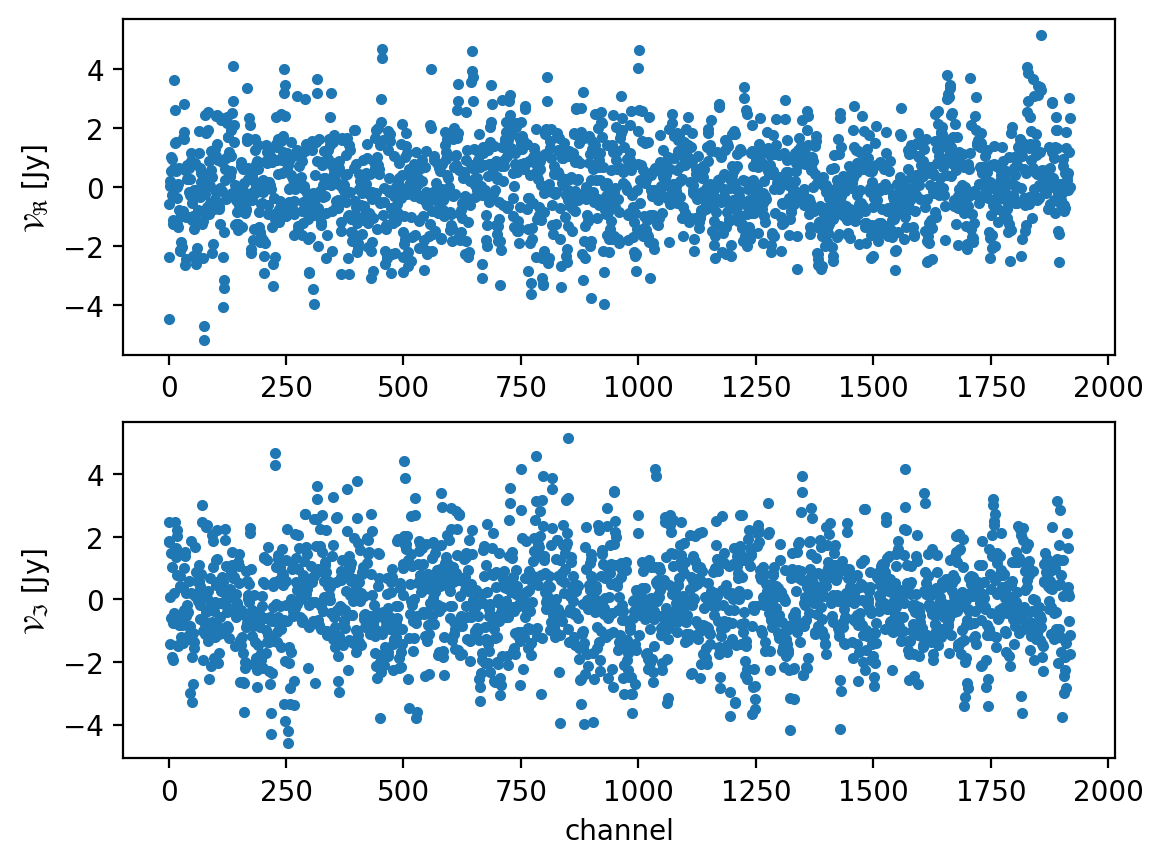

In [10]:
fig, ax = plt.subplots(nrows=2)
ax[0].plot(XX_sb_time.real, ".")
ax[1].plot(XX_sb_time.imag, ".")
ax[1].set_xlabel("channel")
ax[0].set_ylabel(r"$\mathcal{V}_\Re$ [Jy]")
ax[1].set_ylabel(r"$\mathcal{V}_\Im$ [Jy]")

Let's examine the autocorrelation of this data

In [11]:
def autocorrelation(x, norm=True):
    """
    Args:
        x : timeseries
        
    Returns:
        the normalized autocorrelation
    """
    ac = np.correlate(x, x, mode="full")
    if norm:
        ac /= np.max(ac)
    return ac[ac.size // 2:]

## Examining the correlation coefficients

In [12]:
arr = np.array([XX_sb_time.real, XX_sb_time.imag])
print(np.corrcoef(arr))

[[ 1.         -0.01075081]
 [-0.01075081  1.        ]]


In [13]:
arr_staggered = np.array([XX_sb_time.real[1:], XX_sb_time.imag[:-1]])
print(np.corrcoef(arr_staggered))

[[ 1.         -0.01121673]
 [-0.01121673  1.        ]]


In [14]:
arr_re_staggered = np.array([XX_sb_time.real[1:], XX_sb_time.real[:-1]])
print(np.corrcoef(arr_re_staggered))

[[1.         0.66061313]
 [0.66061313 1.        ]]


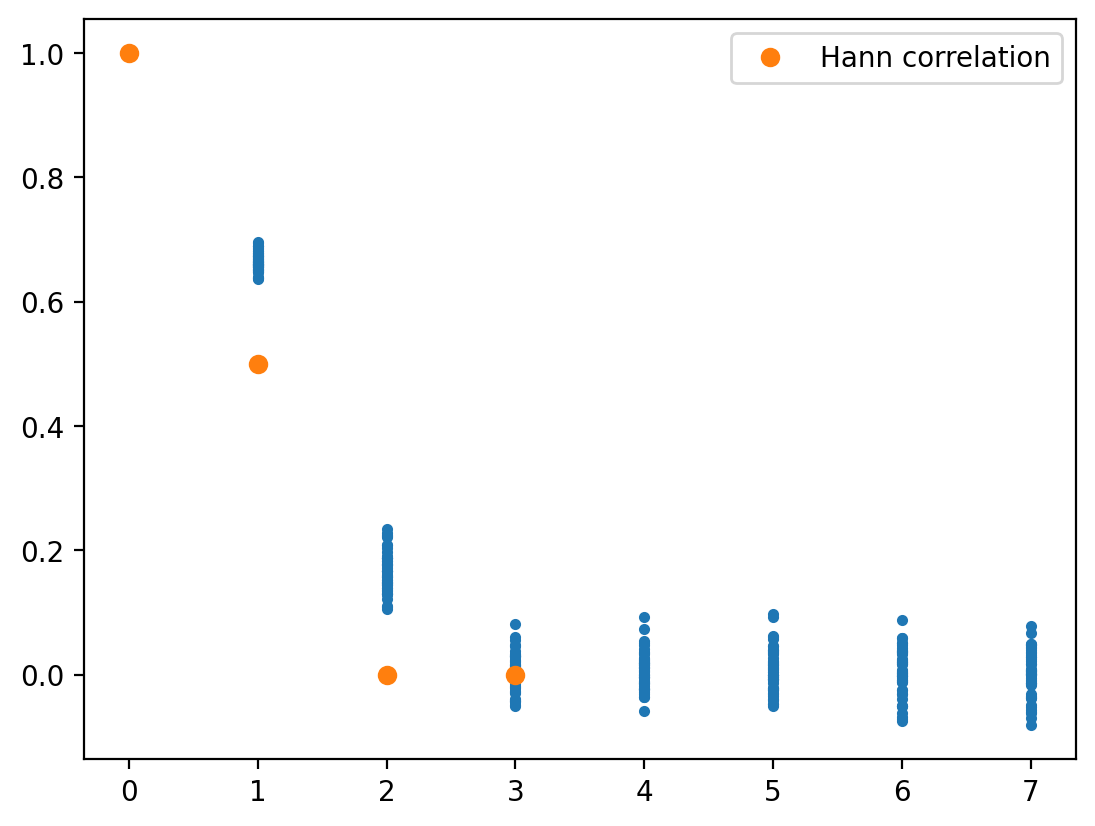

In [15]:
# Let's try plotting the autocorrelation window for all timestamps
for t in np.unique(time):
    ind_time = (time == t)
    ind_sb_time = ind_sb & ind_time
    
    XX_sb_time = np.squeeze(XX_centered[:,ind_sb_time])
    
    ac = autocorrelation(XX_sb_time.real)
    # normalize to peak
    ac /= np.max(ac)
    
    plt.plot(ac[:8], ".", color="C0")
    
ys_hanning = [1, 0.5, 0.0, 0.0]    
plt.plot(ys_hanning, "o", color="C1", label="Hann correlation")
plt.legend(loc="upper right")

## Padding the transform

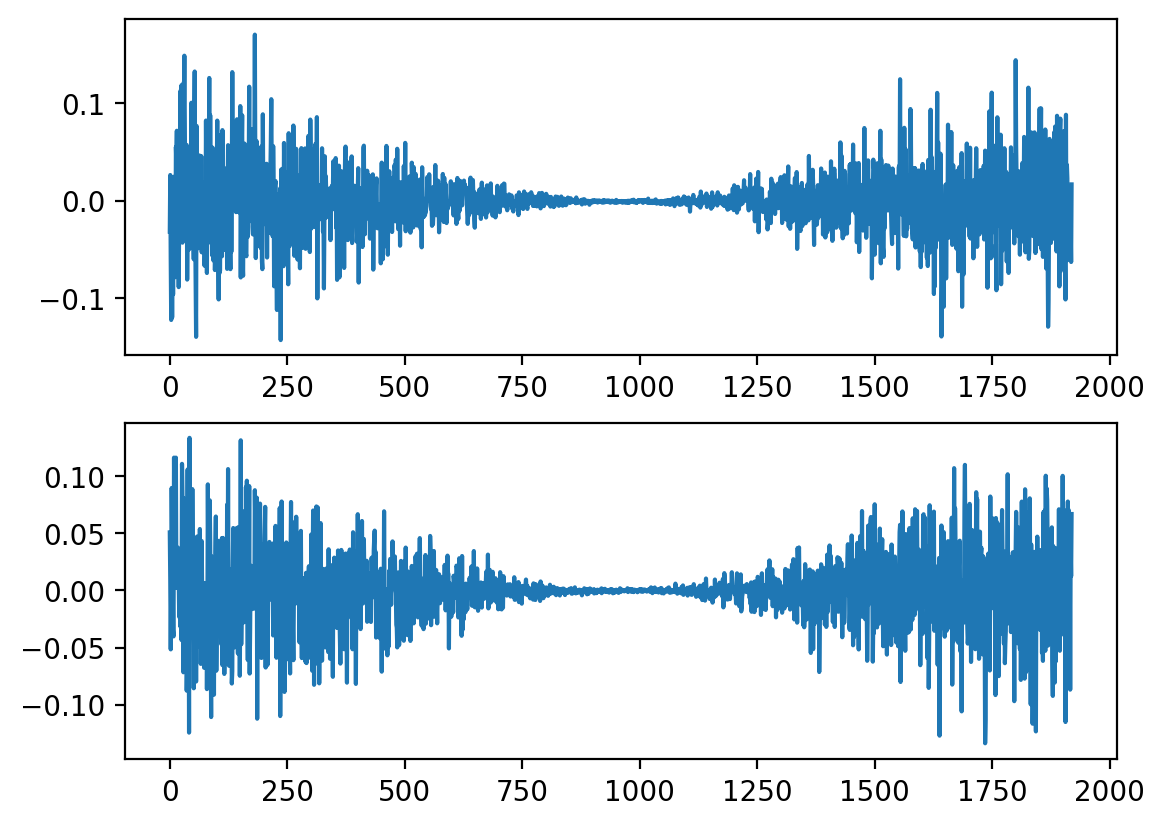

In [16]:
autocorr_space = np.fft.ifft(XX_sb_time)
fig, ax = plt.subplots(nrows=2)
ax[0].plot(autocorr_space.real)
ax[1].plot(autocorr_space.imag)

let's try packing it with zeroes

In [17]:
autocorr_shifted = np.fft.fftshift(autocorr_space)

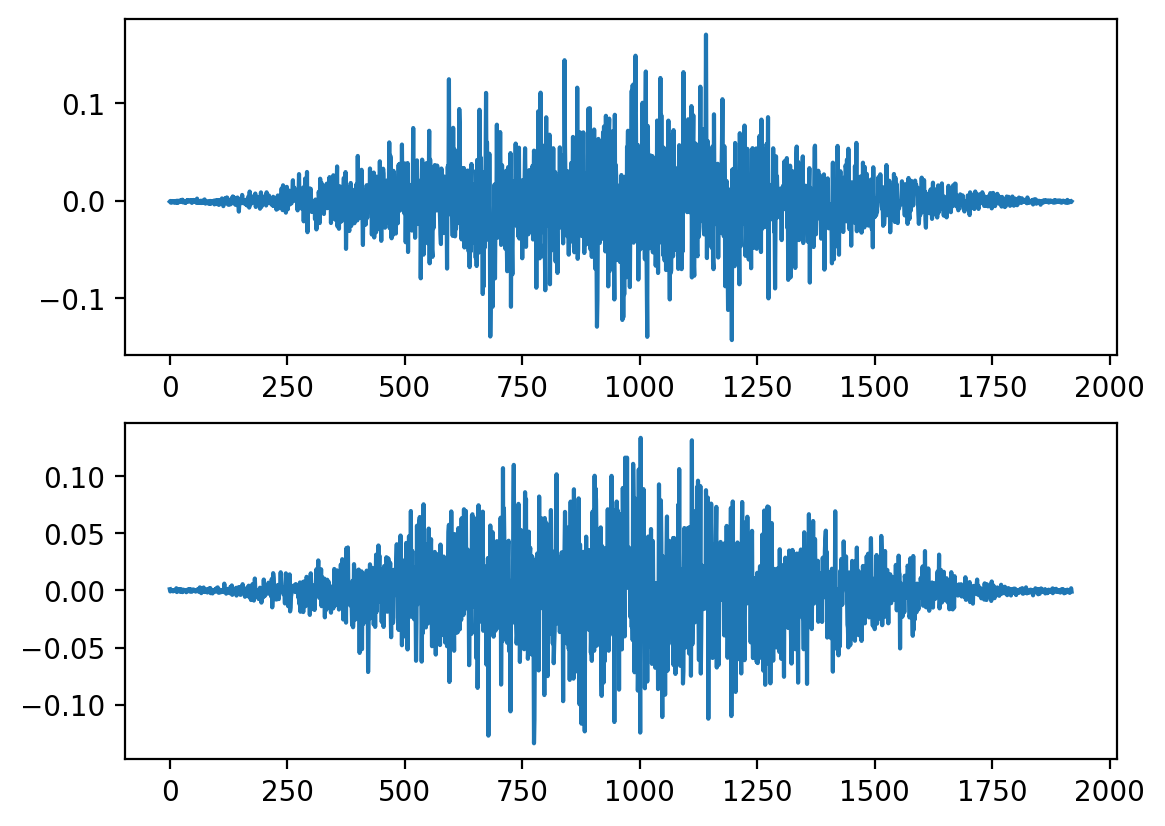

In [18]:
fig, ax = plt.subplots(nrows=2)
ax[0].plot(autocorr_shifted.real)
ax[1].plot(autocorr_shifted.imag)

In [19]:
N = 10
autocorr_packed = np.concatenate((np.zeros(N//2 * len(autocorr_shifted)), autocorr_shifted, np.zeros(N//2 * len(autocorr_shifted))))

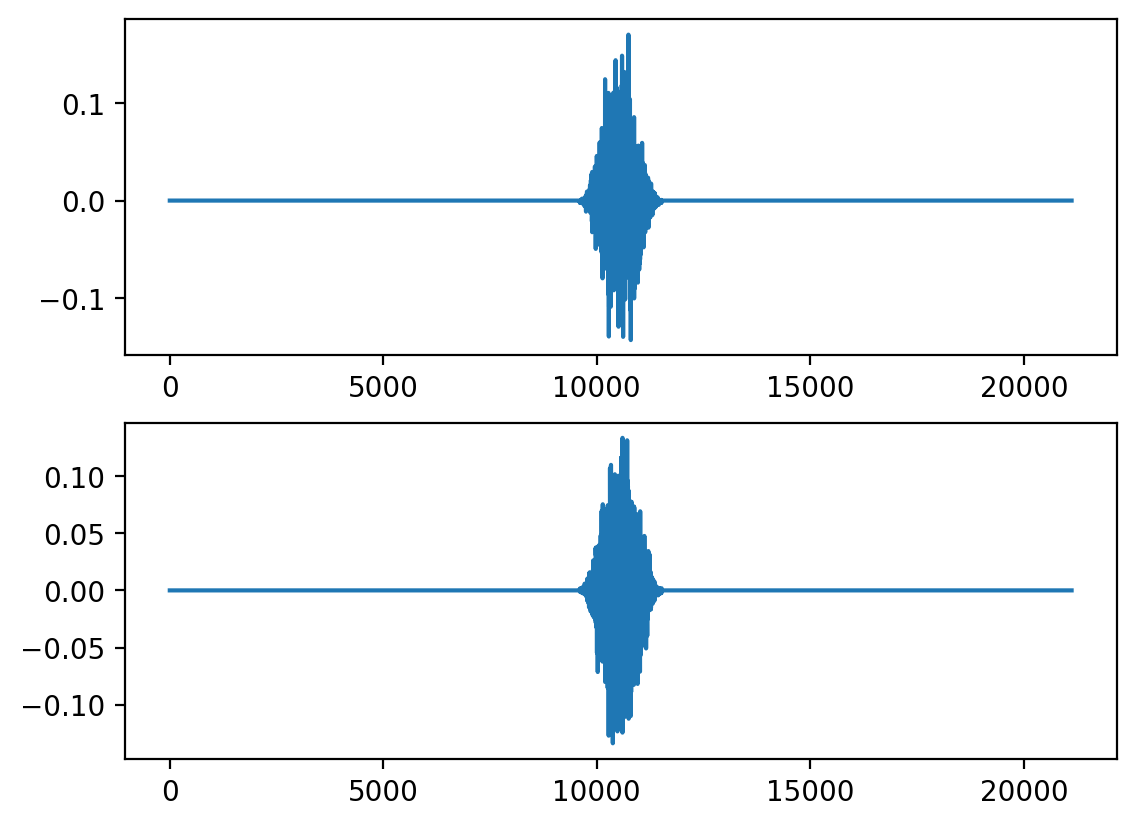

In [20]:
fig, ax = plt.subplots(nrows=2)
ax[0].plot(autocorr_packed.real)
ax[1].plot(autocorr_packed.imag)

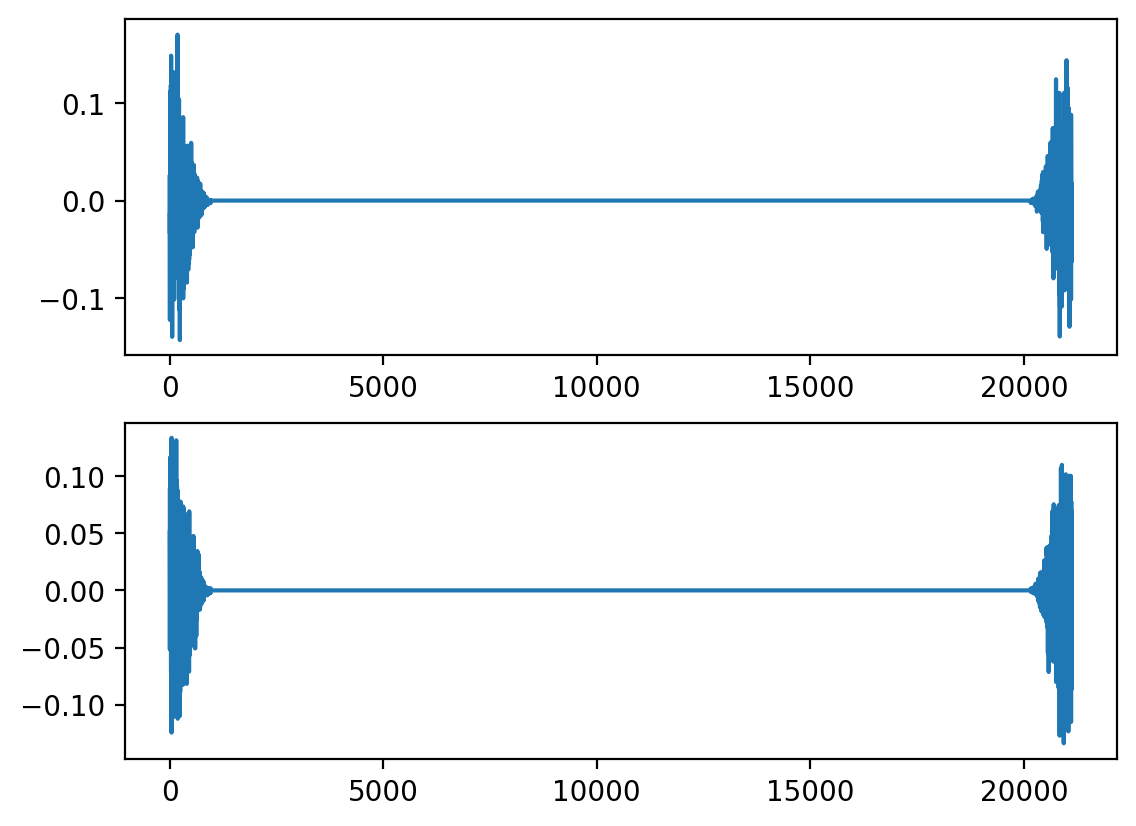

In [21]:
autocorr_packed_shifted = np.fft.fftshift(autocorr_packed)
fig, ax = plt.subplots(nrows=2)
ax[0].plot(autocorr_packed_shifted.real)
ax[1].plot(autocorr_packed_shifted.imag)

(1000.0, 1100.0)

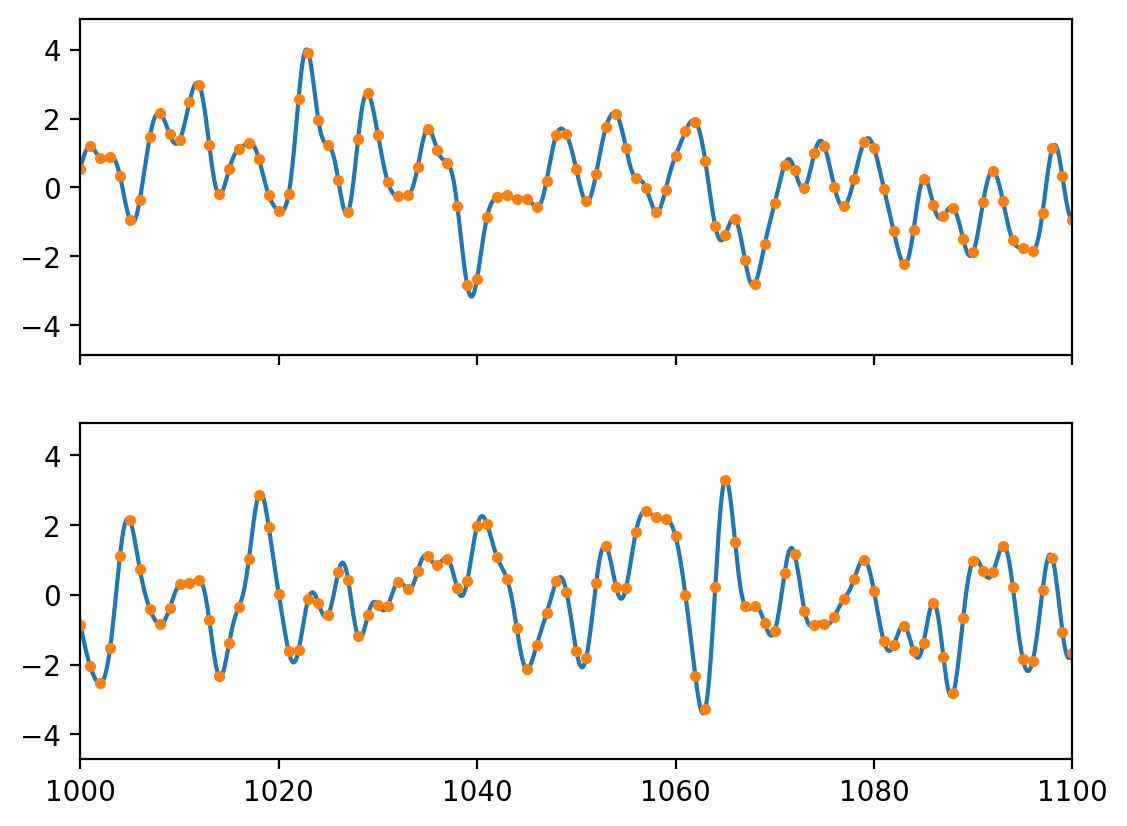

In [22]:
spectrum = np.fft.fft(autocorr_packed_shifted)
xchan = np.arange(nchan)
extraxchan = 1/(N + 1) * np.arange(nchan * (N + 1))

fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(extraxchan, spectrum.real)
ax[0].plot(xchan, XX_sb_time.real, ".")

ax[1].plot(extraxchan, spectrum.imag)
ax[1].plot(xchan, XX_sb_time.imag, ".")
ax[1].set_xlim(1000, 1100)

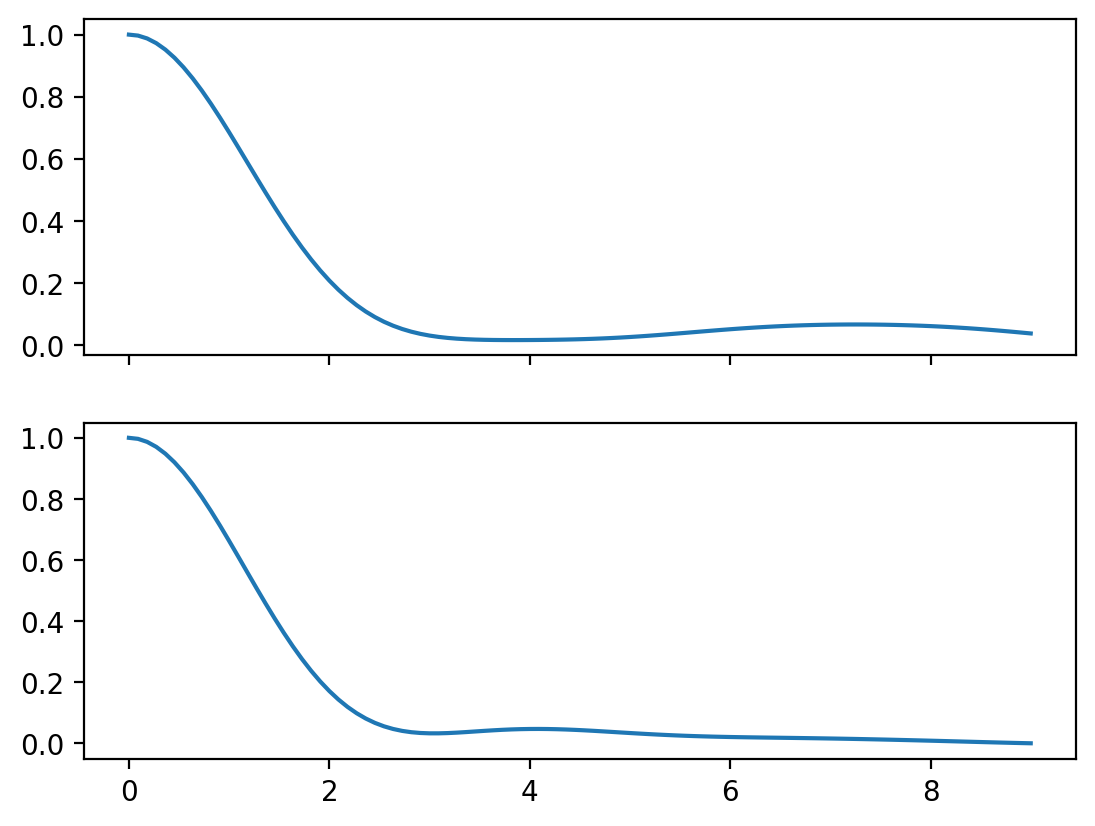

In [23]:
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(extraxchan[:100], autocorrelation(spectrum.real)[:100])
# ax[0].plot(xchan, XX_sb_time.real, ".")

ax[1].plot(extraxchan[:100], autocorrelation(spectrum.imag)[:100])
# ax[1].plot(xchan, XX_sb_time.imag, ".")

NameError: name 'ftpad' is not defined

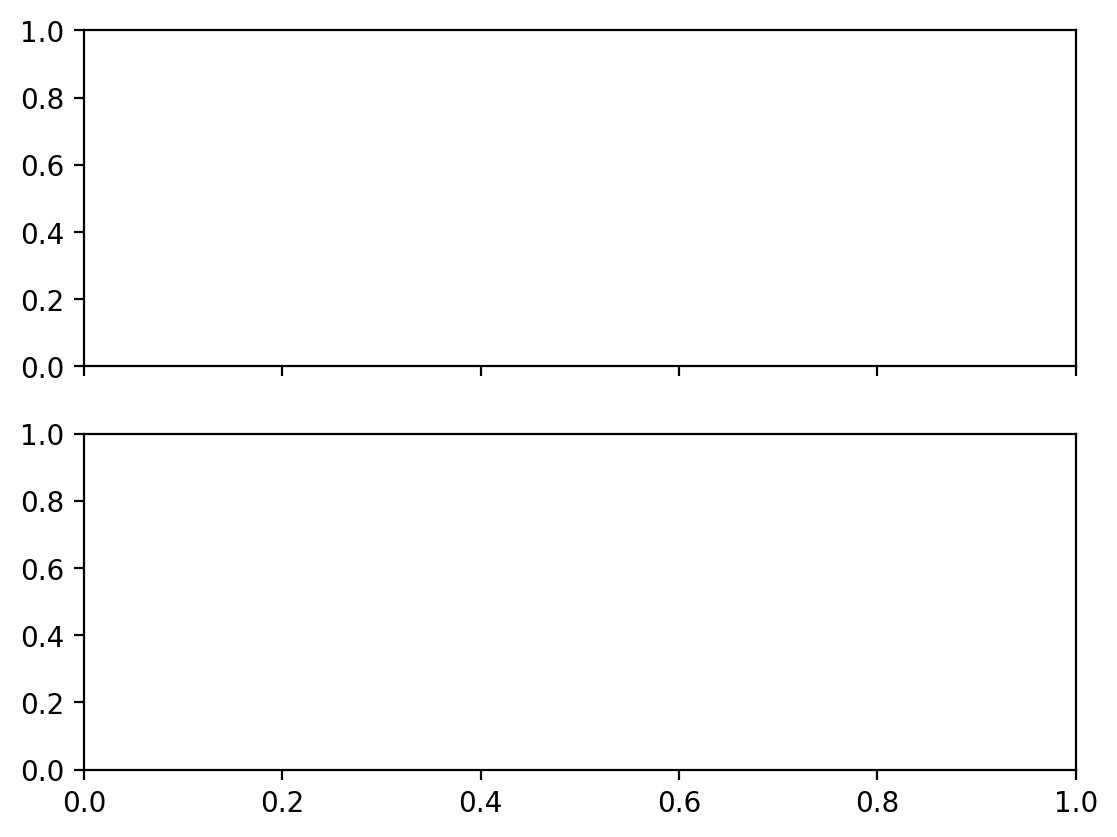

In [24]:
fig,ax = plt.subplots(nrows=2, sharex=True)
xchan = np.arange(nchan)
npad = 10
extraxchan = 1/npad * np.arange(nchan * npad)
ax[0].plot(extraxchan, npad * ftpad(XX_sb_time, npad).real)
ax[0].plot(xchan, XX_sb_time.real, ".")
ax[0].plot(r"$\mathcal{V}_\Re$")
ax[1].plot(extraxchan, npad * ftpad(XX_sb_time, npad).imag)
ax[1].plot(xchan, XX_sb_time.imag, ".")
ax[1].plot(r"$\mathcal{V}_\Im$")
ax[0].set_xlim(490, 535)


In [ ]:
fig, ax = plt.subplots(nrows=2)
npad = 10
ax[0].plot(autocorrelation(ftpad(XX_sb_time, padfactor=npad).real, norm=True)[:50], ".", label="data correlation")
xs_hanning = npad * np.arange(4)
ys_hanning = [1, 0.5, 0.0, 0.0]    

ax[0].plot(xs_hanning, ys_hanning, "o", label="Hann correlation")

ax[1].plot(autocorrelation(ftpad(XX_sb_time, padfactor=npad).imag, norm=True)[:50], ".", label="data correlation")
ax[1].plot(xs_hanning, ys_hanning, "o", label="Hann correlation")

plt.xlabel("channel lag")
plt.ylabel("normalized autocorrelation")
plt.legend(loc="upper right")

In [ ]:
fig, ax = plt.subplots(nrows=2)
ax[0].plot(autocorrelation(np.abs(XX_sb_time), norm=True)[:10], ".", label="data correlation")
ys_hanning = [1, 0.5, 0.0, 0.0]    
ax[0].plot(ys_hanning, "o", label="Hann correlation")
plt.xlabel("channel lag")
plt.ylabel("normalized autocorrelation")
plt.legend(loc="upper right")

## Linear interpolation effects
Let's see what happens to the correlation spectrum when we linearly interpolate the data.

In [25]:
ind_time = (time == np.min(time))
ind_sb = (ant1 == 21) & (ant2 == 23)
ind_sb_time = ind_sb & ind_time
XX_sb_time = np.squeeze(XX_centered[:,ind_sb_time])
nchan = XX_sb_time.shape[0]

chan_orig = np.arange(nchan)

In [26]:
interp = interp1d(chan_orig, XX_sb_time.real, kind="linear")

In [27]:
chan_quarter = chan_orig[:-1] + 0.25
XX_quarter = interp(chan_quarter)

In [28]:
chan_half = chan_orig[:-1] + 0.5
XX_half = interp(chan_half)

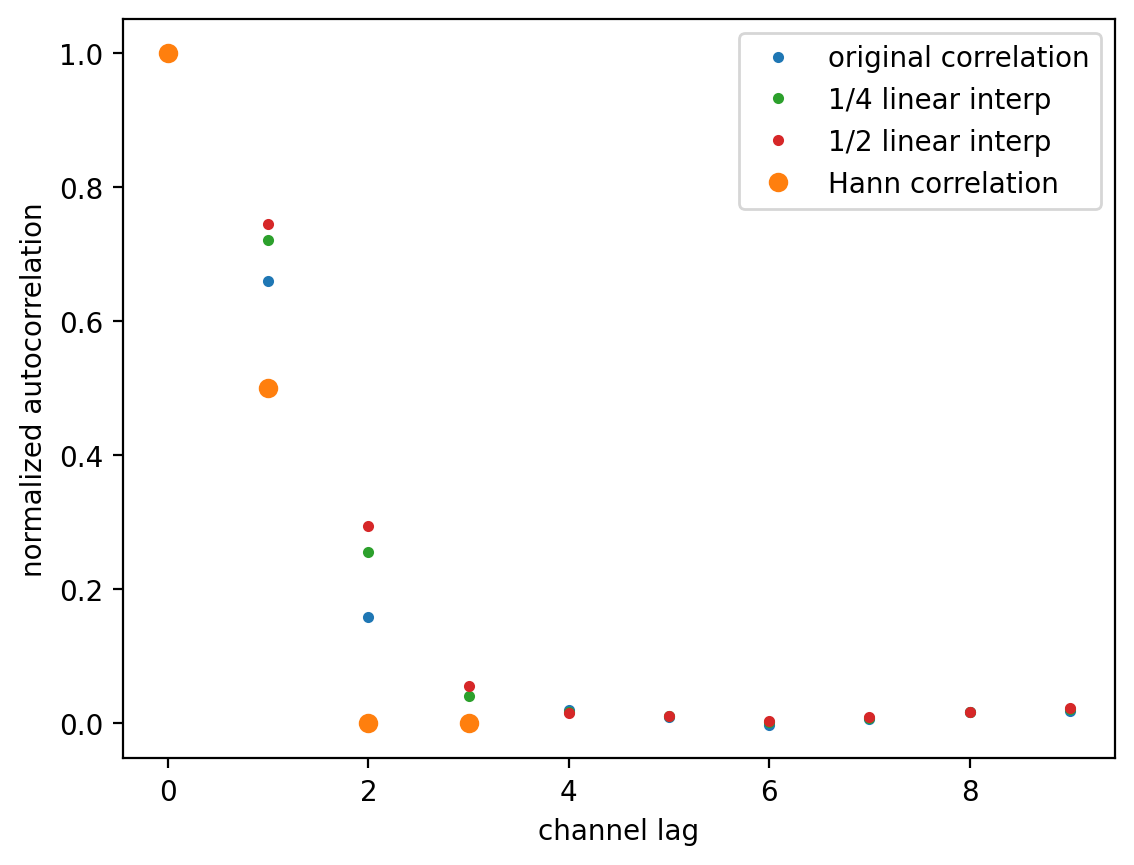

In [29]:
plt.plot(autocorrelation(XX_sb_time.real)[:10], "C0", marker=".", ls="", label="original correlation")
plt.plot(autocorrelation(XX_quarter)[:10], marker=".", ls="", color="C2", label="1/4 linear interp")
plt.plot(autocorrelation(XX_half)[:10], marker=".", ls="", color="C3", label="1/2 linear interp")
ys_hanning = [1, 0.5, 0.0, 0.0]    
plt.plot(ys_hanning, "o", color="C1", label="Hann correlation")
plt.xlabel("channel lag")
plt.ylabel("normalized autocorrelation")
plt.legend(loc="upper right")

## Examples with mock noise
Autocorrelations of mock noise

In [30]:
rho_noise = np.random.normal(size=nchan) + np.random.normal(size=nchan) * 1.0j

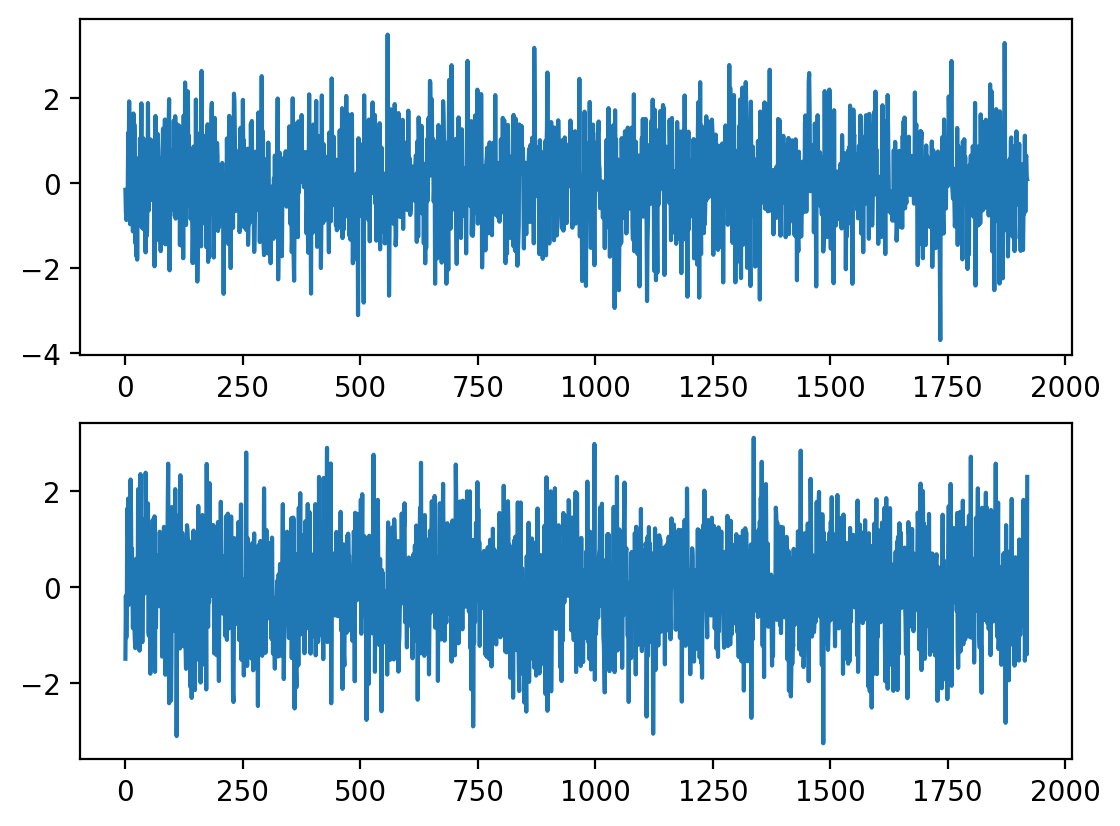

In [31]:
fig, ax = plt.subplots(nrows=2)
ax[0].plot(rho_noise.real)
ax[1].plot(rho_noise.imag)

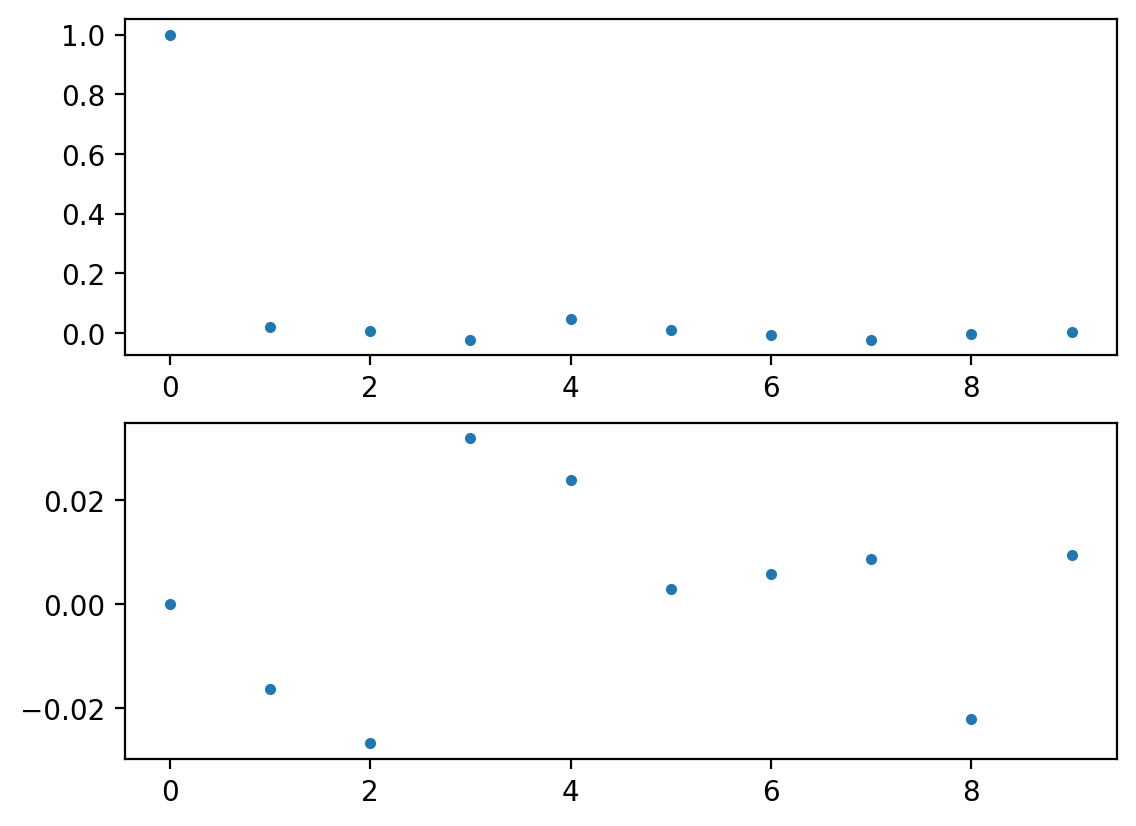

In [32]:
fig, ax = plt.subplots(nrows=2)
ax[0].plot(autocorrelation(rho_noise).real[:10], ".")
ax[1].plot(autocorrelation(rho_noise).imag[:10], ".")

In [33]:
spectrum_noise = np.fft.fftshift(np.fft.fft(np.fft.fftshift(np.hanning(nchan) * rho_noise)))

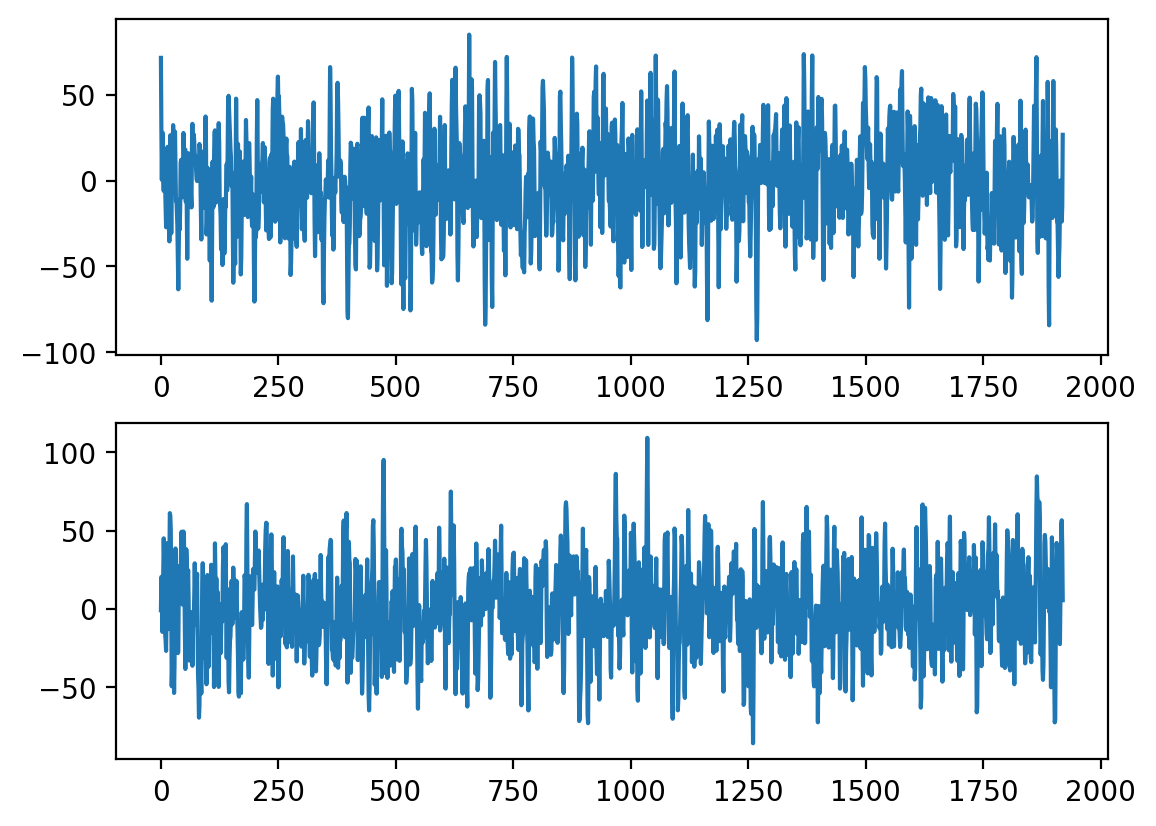

In [34]:
fig, ax = plt.subplots(nrows=2)
ax[0].plot(spectrum_noise.real)
ax[1].plot(spectrum_noise.imag)

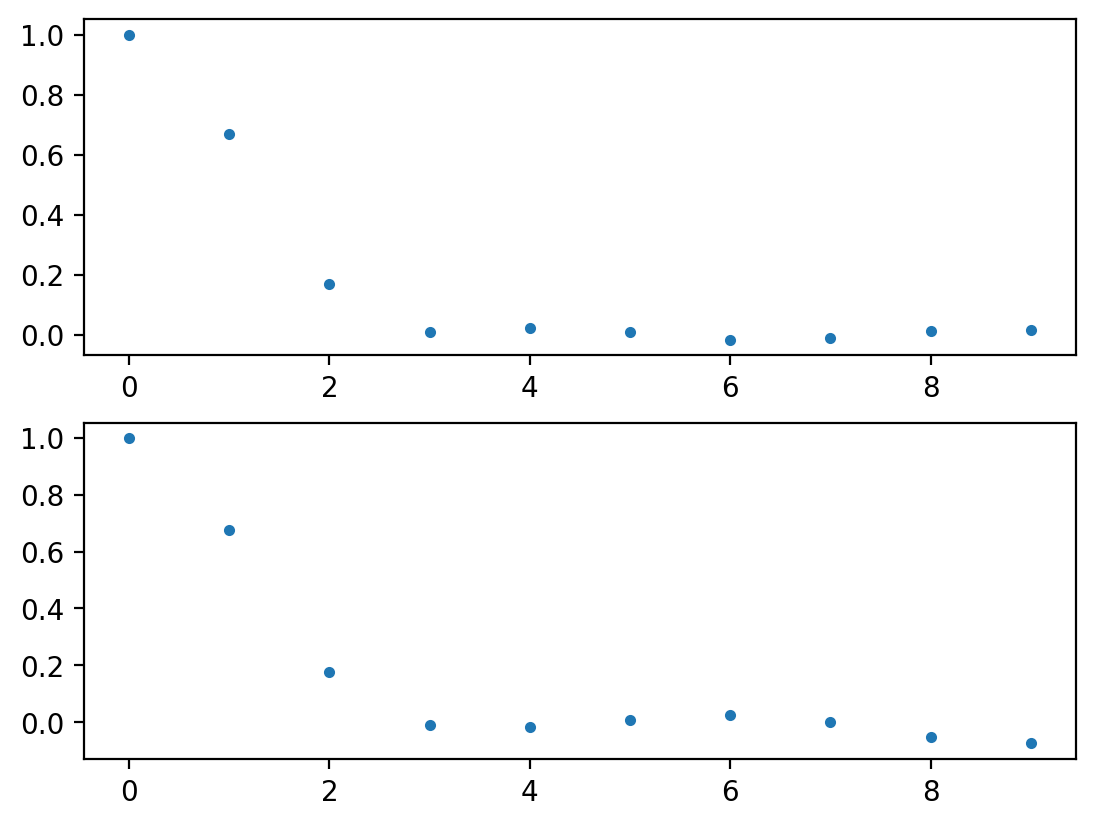

In [35]:
fig, ax = plt.subplots(nrows=2)
ax[0].plot(autocorrelation(spectrum_noise.real)[:10], ".")
ax[1].plot(autocorrelation(spectrum_noise.imag)[:10], ".")

In [36]:
hann = np.fft.fftshift(np.fft.fft(np.fft.fftshift(np.hanning(nchan))))

In [41]:
nchan

1920

(957.0, 963.0)

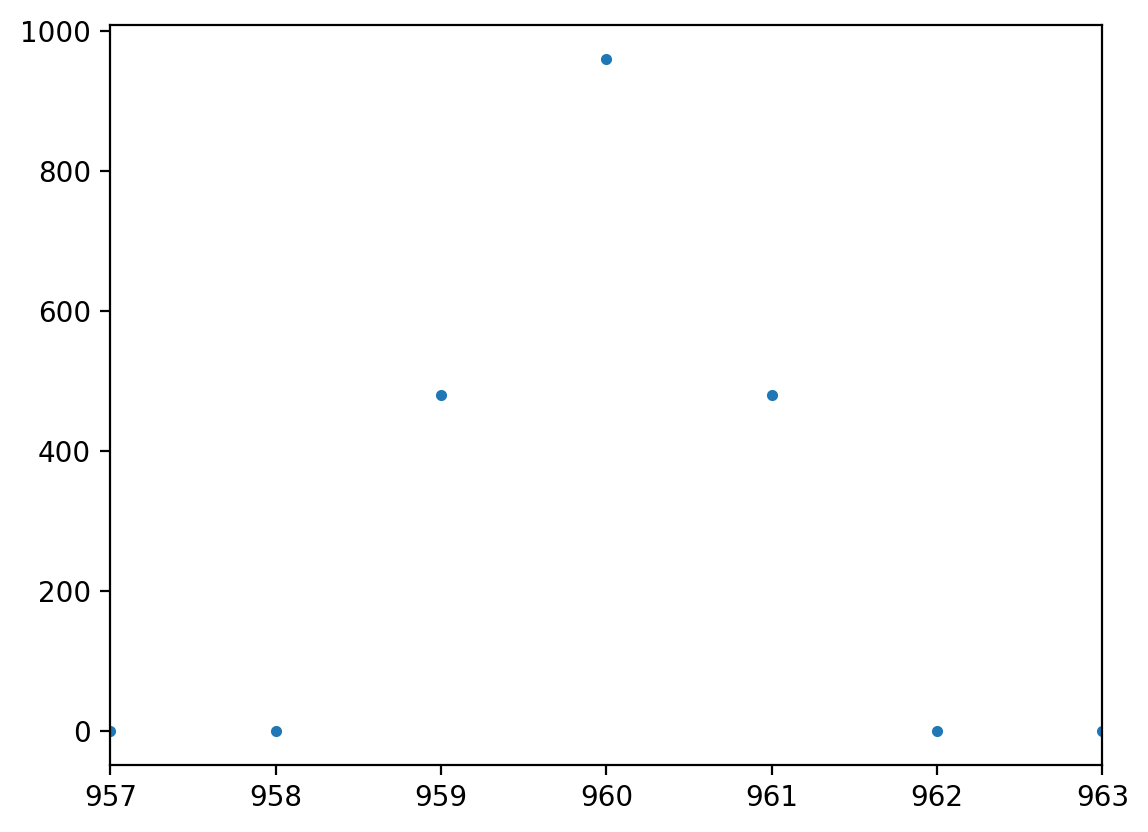

In [43]:
fig, ax = plt.subplots(nrows=1)
ax.plot(hann, ".")
ax.set_xlim(nchan//2 - 3, nchan//2 + 3)

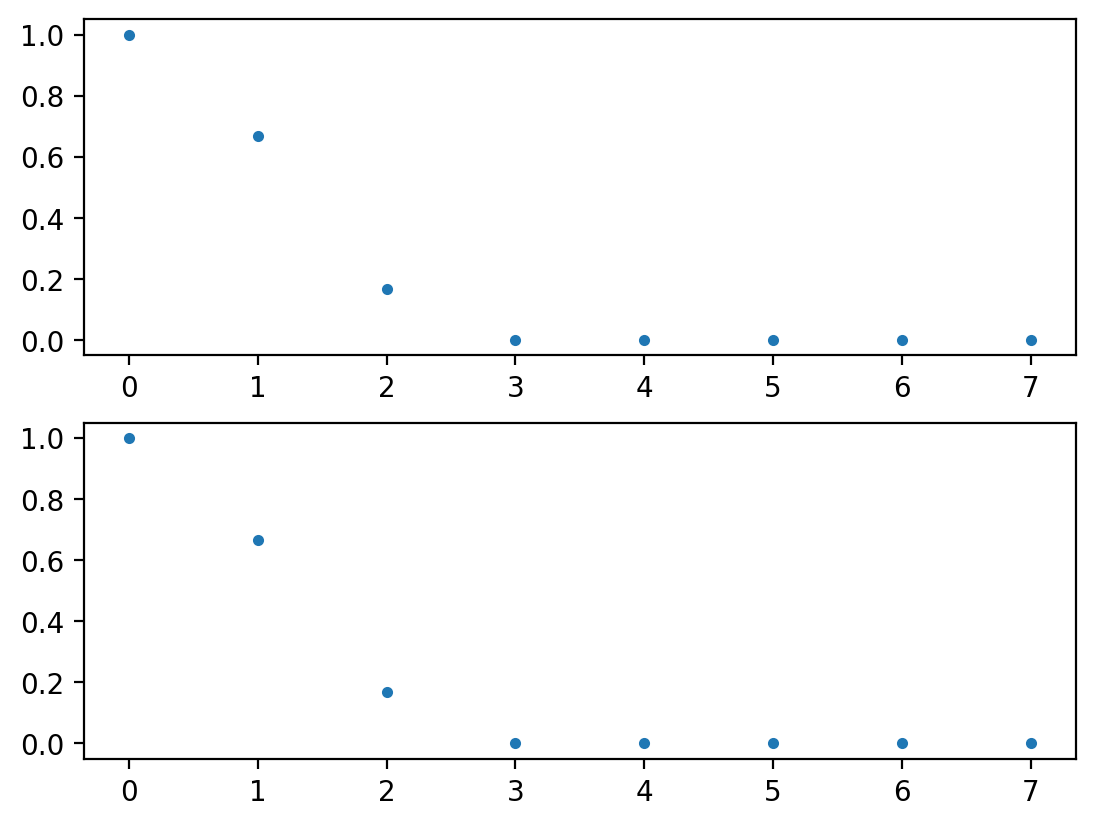

In [59]:
fig, ax = plt.subplots(nrows=2)
ax[0].plot(autocorrelation(hann)[:8], ".")
ax[1].plot(np.abs(autocorrelation(hann)[:8]), ".")

In [58]:
autocorrelation(hann)[:4]

array([1.00000000e+00+0.00000000e+00j, 6.66955104e-01+1.09130371e-03j,
       1.67027686e-01+5.46598775e-04j, 5.22687372e-05+2.56575624e-07j])

The autocorrelation function measures the convolution of the stream with itself. It's naturally a broadening process. So, I don't think it's the right thing to be doing here.


I think the question here is whether the convolution kernel equals the covariance function. I think the answer is no. 


The covariance function is the square of the convolutional kernel. The covariance function has units of variance, whereas the convolutional kernel is technically unitless. But the covariance function would come from the square of the convolutional kernel, if the convolutional kernel were symmetric.

We should write down this as an affine transformation of the matrices. I think it involves the vector product the way we normally work with matrices. And that gives rise to the extra covariance length.

In [51]:
def analytical_hann_covariance(x):
    return 0.25 * (3/2 * np.sinc(x) + 1/4 * np.sinc(2 - x) + 1/4 * np.sinc(2 + x) + np.sinc(1 - x) + np.sinc(1 + x))

In [52]:
for x in [0, 1, 2, 3, 4]:
    print(x, analytical_hann_covariance(x))

0 0.375
1 0.25
2 0.0625
3 0.0
4 1.5407439555097887e-33


In [53]:
5/6

0.8333333333333334

In [54]:
2/3

0.6666666666666666

In [55]:
1/6

0.16666666666666666